# 下载数据集

In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/watermelon/Watermelon87_Semantic_Seg_Mask.zip
!unzip Watermelon87_Semantic_Seg_Mask.zip -d data

# 可视化探索数据集

## 导入工具包

In [9]:
import os

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import mmcv
import mmengine
from mmseg.apis import init_model, inference_model, show_result_pyplot

import matplotlib.pyplot as plt
%matplotlib inline

## 查看单张图像及其语义分割标注

In [ ]:
# 指定单张图像路径
img_path = 'data/Watermelon87_Semantic_Seg_Mask/img_dir/train/21746.1.jpg'
mask_path = 'data/Watermelon87_Semantic_Seg_Mask/ann_dir/train/21746.png'

In [ ]:
Image.open(img_path)

In [ ]:
Image.open(mask_path)

In [ ]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [ ]:
img.shape

In [ ]:
mask.shape

## mask灰度图标注含义

In [ ]:
# mask 语义分割标注，与原图大小相同
np.unique(mask)

| 类别编号 | 类别名称   |
| -------- | ---------- |
| 0        | Land       |
| 1        | Road       |
| 2        | Building   |
| 3        | Vegetation |
| 4        | Water      |
| 5        | Unlabeled  |

In [ ]:
# 可视化语义分割标注
plt.imshow(mask[:,:,0])
plt.show()

## 叠加在原图上显示

In [ ]:
plt.imshow(img[:,:,::-1])
plt.imshow(mask[:,:,0], alpha=0.4) # alpha 高亮区域透明度，越小越接近原图
plt.axis('off')
plt.show()

## 批量可视化图像和标注

In [ ]:
# 指定图像和标注路径
PATH_IMAGE = 'data/Watermelon87_Semantic_Seg_Mask/img_dir/train'
PATH_MASKS = 'data/Watermelon87_Semantic_Seg_Mask/ann_dir/train'

In [ ]:
# n行n列可视化
n = 5

# 标注区域透明度
opacity = 0.5

fig, axes = plt.subplots(nrows=n, ncols=n, sharex=True, figsize=(12,12))

for i, file_name in enumerate(os.listdir(PATH_IMAGE)[:n**2]):
    
    # 载入图像和标注
    img_path = os.path.join(PATH_IMAGE, file_name)
    mask_path = os.path.join(PATH_MASKS, file_name.split('.')[0]+'.png')
    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    
    # 可视化
    axes[i//n, i%n].imshow(img)
    axes[i//n, i%n].imshow(mask[:,:,0], alpha=opacity)
    axes[i//n, i%n].axis('off') # 关闭坐标轴显示
fig.suptitle('Image and Semantic Label', fontsize=30)
plt.tight_layout()
plt.show()

## 定义数据集类

In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset.py -O mmseg/datasets/watermemlon.py

## 注册数据集类

In [ ]:
!rm -rf mmseg/datasets/__init__.py
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/__init__.py -P mmseg/datasets

## 定义训练及测试pipeline`

In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/DubaiDataset_pipeline.py -O configs/_base_/datasets/WaterMemlon_pipeline.py

## 下载config

In [ ]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/Dubai/pspnet_r50-d8_4xb2-40k_DubaiDataset.py -O configs/pspnet/pspnet_r50-d8_4xb2-40k_WaterMemlon.py

## 载入Config

In [ ]:
from mmengine import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r50-d8_4xb2-40k_WaterMemlon.py')

## 修改config配置文件

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader

# 结果保存目录
cfg.work_dir = './work_dirs/WaterMemlon.py'

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500

# 随机数种子
cfg['randomness'] = dict(seed=0)

## 查看完整config配置文件

In [ ]:
# print(cfg.pretty_text)

## 保存config配置文件

In [ ]:
cfg.dump('configs/pspnet/pspnet-WaterMemlon_20230615.py')

## 载入训练配置文件`

In [ ]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet-WaterMemlon_20230615.py')

## 准备训练

In [ ]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

## 开始训练

如果遇到报错`CUDA out of memeory`，可尝试以下步骤：

1. 调小 batch size

2. 左上角`内核-关闭所有内核`

3. 重启实例，或者使用显存更高的实例即可。

In [ ]:
runner.train()

## 查看python目录

In [ ]:
import sys
print(sys.path)

## 设置Matplotlib中文字体

In [1]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /root/.cache/matplotlib

import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rc("font",family='SimHei') # 中文字体

--2023-06-17 14:54:02--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050868 (9.6M) [application/x-font-ttf]
Saving to: ‘/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’

/opt/conda/lib/pyth 100%[===================>]   9.58M  24.2MB/s    in 0.4s    

2023-06-17 14:54:03 (24.2 MB/s) - ‘/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf’ saved [10050868/10050868]



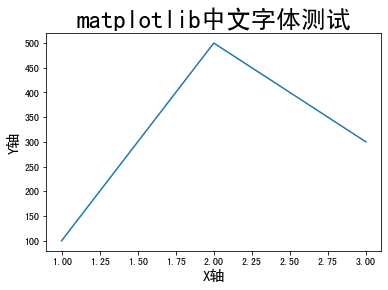

In [2]:
plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

## 载入训练日志

In [3]:
# 日志文件路径
log_path = 'work_dirs/WaterMemlon.py/20230617_142233/vis_data/scalars.json' #需要更改为实际路径

In [4]:
with open(log_path, "r") as f:
    json_list = f.readlines()

In [5]:
len(json_list)

38

In [6]:
eval(json_list[4])

{'lr': 0.009911076035273796,
 'data_time': 0.0062235832214355465,
 'loss': 0.0629101924598217,
 'decode.loss_ce': 0.044754755310714246,
 'decode.acc_seg': 87.078857421875,
 'aux.loss_ce': 0.018155436776578427,
 'aux.acc_seg': 82.8643798828125,
 'time': 0.5854336261749268,
 'memory': 3614,
 'step': 400}

In [10]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()
for each in json_list[:-1]:
    if 'aAcc' in each:
        df_test = df_test.append(eval(each), ignore_index=True)
    else:
        df_train = df_train.append(eval(each), ignore_index=True)

In [11]:
df_train

,lr,data_time,loss,decode.loss_ce,decode.acc_seg,aux.loss_ce,aux.acc_seg,time,memory,step
0,0.009999,0.049834,0.147681,0.103367,33.187866,0.044314,23.461914,1.425799,6130.0,6.0
1,0.009978,0.006455,0.067354,0.045771,80.651855,0.021583,83.132935,0.581496,3614.0,100.0
2,0.009956,0.006144,0.074516,0.052314,84.338379,0.022201,67.199707,0.582712,3614.0,200.0
3,0.009933,0.006703,0.054795,0.038385,83.389282,0.016410,77.926636,0.584389,3614.0,300.0
4,0.009911,0.006224,0.062910,0.044755,87.078857,0.018155,82.864380,0.585434,3614.0,400.0
5,0.009889,0.005829,0.052689,0.037809,72.668457,0.014880,70.614624,0.583577,5330.0,500.0
6,0.009866,0.006274,0.054007,0.038717,82.006836,0.015290,85.751343,0.584092,3614.0,600.0
7,0.009844,0.005902,0.041565,0.029165,89.489746,0.012400,91.165161,0.583757,3614.0,700.0
8,0.009822,0.006290,0.039904,0.027766,83.065796,0.012138,83.554077,0.583456,3614.0,800.0
9,0.009800,0.006186,0.041545,0.028945,89.233398,0.012600,87.475586,0.583913,3614.0,900.0


In [12]:
df_test

,aAcc,mIoU,mAcc,data_time,time,step
0,69.03,26.40,34.34,0.134210,1.786462,400.0
1,80.46,43.12,53.70,0.008483,0.435586,800.0
2,86.05,49.82,57.02,0.007200,0.434911,1200.0
3,85.99,48.27,57.60,0.007433,0.436786,1600.0
4,88.95,56.00,63.07,0.007645,0.432872,2000.0
5,87.92,52.87,59.12,0.008146,0.434670,2400.0
6,89.75,57.07,65.20,0.007398,0.436049,2800.0


## 导出训练日志表格

In [ ]:
df_train.to_csv('训练日志-训练集.csv', index=False)
df_test.to_csv('训练日志-测试集.csv', index=False)

## 可视化辅助函数

In [13]:
from matplotlib import colors as mcolors
import random
random.seed(124)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'indianred', 'brown', 'firebrick', 'maroon', 'darkred', 'red', 'sienna', 'chocolate', 'yellow', 'olivedrab', 'yellowgreen', 'darkolivegreen', 'forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'darkslategray', 'darkslategrey', 'teal', 'darkcyan', 'dodgerblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'slateblue', 'darkslateblue', 'mediumslateblue', 'mediumpurple', 'rebeccapurple', 'blueviolet', 'indigo', 'darkorchid', 'darkviolet', 'mediumorchid', 'purple', 'darkmagenta', 'fuchsia', 'magenta', 'orchid', 'mediumvioletred', 'deeppink', 'hotpink']
markers = [".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
linestyle = ['--', '-.', '-']

def get_line_arg():
    '''
    随机产生一种绘图线型
    '''
    line_arg = {}
    line_arg['color'] = random.choice(colors)
    # line_arg['marker'] = random.choice(markers)
    line_arg['linestyle'] = random.choice(linestyle)
    line_arg['linewidth'] = random.randint(1, 4)
    # line_arg['markersize'] = random.randint(3, 5)
    return line_arg

## 训练集损失函数

In [14]:
metrics = ['loss', 'decode.loss_ce', 'aux.loss_ce']

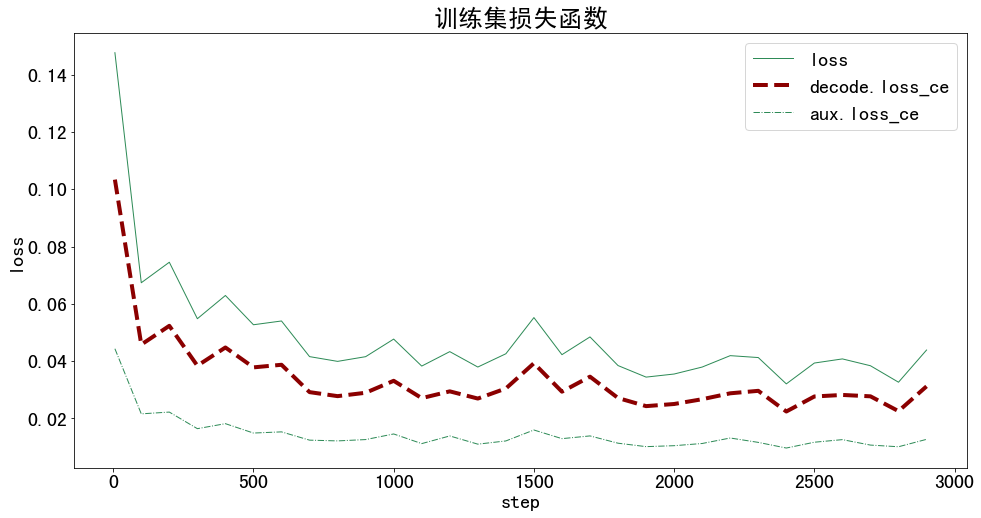

In [15]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('训练集损失函数', fontsize=25)
plt.savefig('训练集损失函数.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

## 训练集准确率

In [16]:
df_train.columns

Index(['lr', 'data_time', 'loss', 'decode.loss_ce', 'decode.acc_seg',
       'aux.loss_ce', 'aux.acc_seg', 'time', 'memory', 'step'],
      dtype='object')

In [17]:
metrics = ['decode.acc_seg', 'aux.acc_seg']

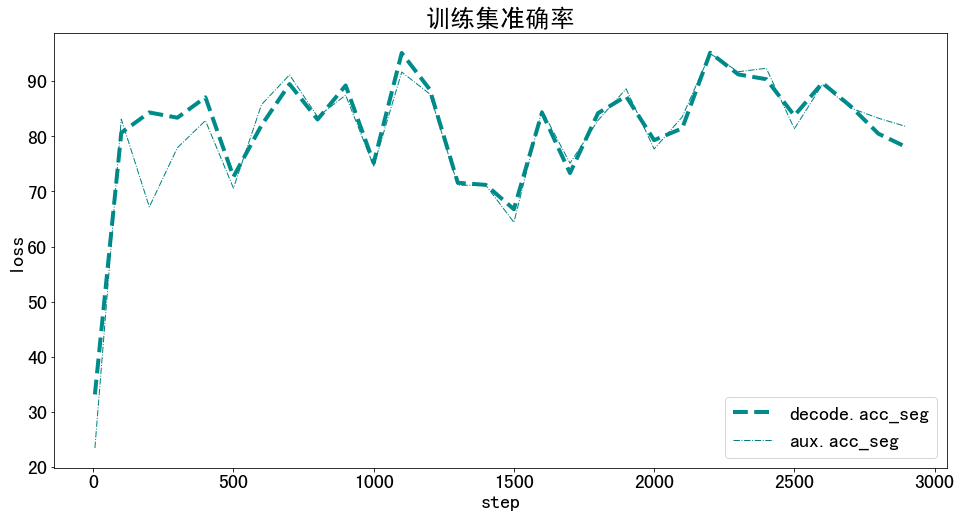

In [18]:
plt.figure(figsize=(16, 8))

x = df_train['step']
for y in metrics:
    plt.plot(x, df_train[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.xlabel('step', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.title('训练集准确率', fontsize=25)
plt.savefig('训练集准确率.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

## 测试集评估指标

In [19]:
df_test.columns

Index(['aAcc', 'mIoU', 'mAcc', 'data_time', 'time', 'step'], dtype='object')

In [20]:
metrics = ['aAcc', 'mIoU', 'mAcc']

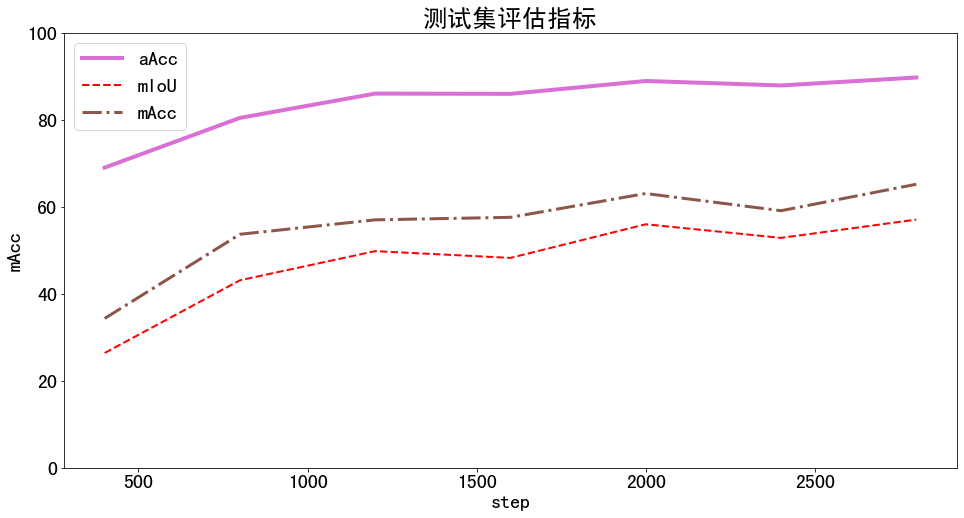

In [21]:
plt.figure(figsize=(16, 8))

x = df_test['step']
for y in metrics:
    plt.plot(x, df_test[y], label=y, **get_line_arg())

plt.tick_params(labelsize=20)
plt.ylim([0, 100])
plt.xlabel('step', fontsize=20)
plt.ylabel(y, fontsize=20)
plt.title('测试集评估指标', fontsize=25)
plt.savefig('测试集分类评估指标.pdf', dpi=120, bbox_inches='tight')

plt.legend(fontsize=20)

plt.show()

## 载入配置文件

In [22]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet-DubaiDataset_20230612.py')

In [23]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/17 14:55:23 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 10.2, V10.2.8
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

/code/temp/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/code/temp/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/code/temp/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


06/17 14:55:26 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/17 14:55:26 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/code/temp/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


## 载入模型

In [24]:
checkpoint_path = './work_dirs/WaterMemlon.py/iter_3000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/WaterMemlon.py/iter_3000.pth


## 载入测试集图像，或新图像

In [25]:
img = mmcv.imread('data/watermelon.jpg')

## 语义分割预测

In [26]:
result = inference_model(model, img)

In [27]:
result.keys()

['pred_sem_seg', 'seg_logits']

In [28]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [29]:
pred_mask.shape

(800, 1200)

In [30]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4])

## 可视化语义分割预测结果

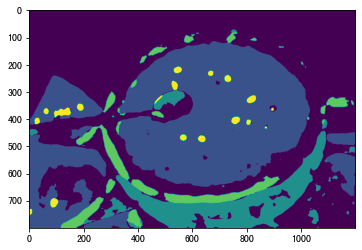

In [31]:
plt.imshow(pred_mask)
plt.show()

06/17 14:56:29 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


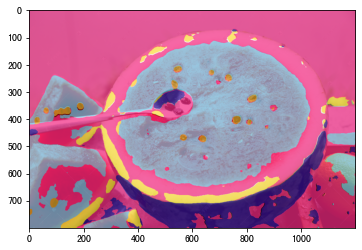

In [32]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

## 获取测试集标注

In [33]:
label = mmcv.imread('data/Watermelon87_Semantic_Seg_Mask/ann_dir/val/R.png')

In [34]:
label.shape

(1333, 2000, 3)

三个通道全部一样，只取一个通道作为标注即可。

In [35]:
label_mask = label[:,:,0]

In [36]:
label_mask.shape

(1333, 2000)

In [37]:
np.unique(label_mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

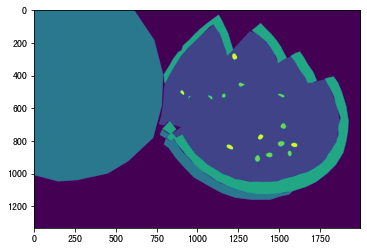

In [38]:
plt.imshow(label_mask)
plt.show()

## 对比测试集标注和语义分割预测结果

In [39]:
# 测试集标注
label_mask.shape

(1333, 2000)

In [40]:
# 语义分割预测结果
pred_mask.shape

(800, 1200)

In [ ]:
# 真实为前景，预测为前景
TP = (label_mask == 1) & (pred_mask==1)

In [ ]:
# 真实为背景，预测为背景
TN = (label_mask == 0) & (pred_mask==0)

In [ ]:
# 真实为前景，预测为背景
FN = (label_mask == 1) & (pred_mask==0)

In [ ]:
# 真实为背景，预测为前景
FP = (label_mask == 0) & (pred_mask==1)

In [ ]:
plt.imshow(TP)
plt.show()

In [ ]:
confusion_map = TP * 255 + FP * 150 + FN * 80 + TN * 30

In [ ]:
plt.imshow(confusion_map)
plt.show()

## 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix_model = confusion_matrix(label_mask.flatten(), pred_mask.flatten())

In [ ]:
confusion_matrix_model

In [ ]:
import itertools
def cnf_matrix_plotter(cm, classes, cmap=plt.cm.Blues):
    """
    传入混淆矩阵和标签名称列表，绘制混淆矩阵
    """
    plt.figure(figsize=(10, 10))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.colorbar() # 色条
    tick_marks = np.arange(len(classes))
    
    plt.title('Confusion Matrix', fontsize=30)
    plt.xlabel('Pred', fontsize=25, c='r')
    plt.ylabel('True', fontsize=25, c='r')
    plt.tick_params(labelsize=16) # 设置类别文字大小
    plt.xticks(tick_marks, classes, rotation=90) # 横轴文字旋转
    plt.yticks(tick_marks, classes)
    
    # 写数字
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

    plt.tight_layout()

    plt.savefig('混淆矩阵.pdf', dpi=300) # 保存图像
    plt.show()

In [ ]:
classes = ['/', 'red', 'green', 'white', 'seed-black', 'white']

In [ ]:
cnf_matrix_plotter(confusion_matrix_model, classes, cmap='Blues')

Unlabeled类别，既无预测结果，也无标签，因此混淆矩阵中不显示。

## 测试集精度指标

In [4]:
!python tools/test.py configs/pspnet/pspnet-WaterMemlon_20230615.py work_dirs/WaterMemlon.py/iter_3000.pth

06/17 15:17:42 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Feb 26 2021, 18:47:35) [GCC 7.3.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 10.2, V10.2.8
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.2-Product Build 20210312 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=

## 速度指标-FPS

In [5]:
!python tools/analysis_tools/benchmark.py configs/pspnet/pspnet-WaterMemlon_20230615.py work_dirs/WaterMemlon.py/iter_3000.pth

Run 1:
Traceback (most recent call last):
  File "tools/analysis_tools/benchmark.py", line 121, in <module>
    main()
  File "tools/analysis_tools/benchmark.py", line 61, in main
    data_loader = Runner.build_dataloader(cfg.test_dataloader)
  File "/opt/conda/lib/python3.7/site-packages/mmengine/runner/runner.py", line 1346, in build_dataloader
    dataset = DATASETS.build(dataset_cfg)
  File "/opt/conda/lib/python3.7/site-packages/mmengine/registry/registry.py", line 548, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "/opt/conda/lib/python3.7/site-packages/mmengine/registry/build_functions.py", line 101, in build_from_cfg
    f'{obj_type} is not in the {registry.name} registry. '
KeyError: 'WaterMemlon is not in the dataset registry. Please check whether the value of `WaterMemlon` is correct or it was registered as expected. More details can be found at https://mmengine.readthedocs.io/en/latest/advanced_tutorials/config.html#import-the-custom-module